In [35]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import scipy as sp
import scipy.stats
import yfinance as yf
from matplotlib import gridspec
pd.options.mode.chained_assignment = None  # default='warn'

import pandas_ta as ta

plt.style.use('ggplot')

Most of Technical Indicators used in quantitative trading are useless, the indicators introduced here are purely demonstrative purpose, they are mostly useless in trading practice.

# <font face="gotham" color="purple"> Moving Average </font>

## <font face="gotham" color="purple"> Simple Moving Average </font>

Simple moving average takes the formula
$$
\begin{aligned}
S M A_k & =\frac{p_{n-k+1}+p_{n-k+2} \cdots+p_n}{k} \\
& =\frac{1}{k} \sum_{i=n-k+1}^n p_i
\end{aligned}
$$
Basically it calculates mean with a rolling window.

In [2]:
start_date = '2010-1-1'
end_date = dt.datetime.today()
usdjpy = pdr.data.DataReader(name = 'DEXJPUS', data_source = 'fred', start = start_date, end = end_date).dropna()
usdjpy.columns = ['USDJPY']

In [3]:
def get_sma(data, periods):
    sma = data.rolling(int(periods)).mean()
    return sma

In [4]:
usdjpy_sma50 = get_sma(data=usdjpy, periods=50)
usdjpy_sma252 = get_sma(data=usdjpy, periods=252)

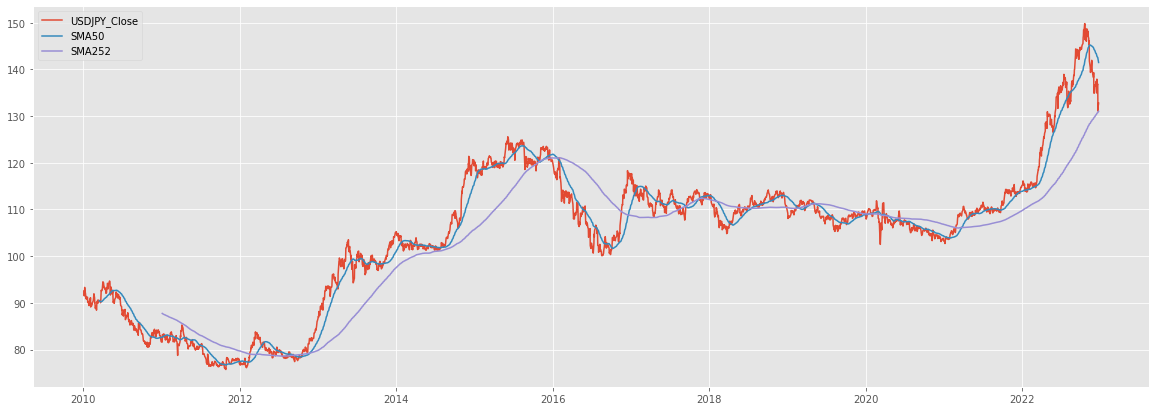

In [5]:
fig, ax = plt.subplots(figsize=(20, 7)) 
ax.plot(usdjpy, label='USDJPY_Close')
ax.plot(usdjpy_sma50, label='SMA50')
ax.plot(usdjpy_sma252, label='SMA252')
ax.legend()
plt.show()

## <font face="gotham" color="purple"> Exponential Moving Average </font>

This is the formula of Exponential Moving Average

$$
\begin{gathered}
K=\frac{2}{(n+1)} \\
E M A=K \cdot p+(1-K) \cdot E M A_{-1}
\end{gathered}
$$

The _smoothing constant_ determines the weight to the most recent price, suppose your lag period is $7$
$$
K= \frac{2}{7+1}
$$
$K=.2$ means you give $20\%$ weight to the most recent data.

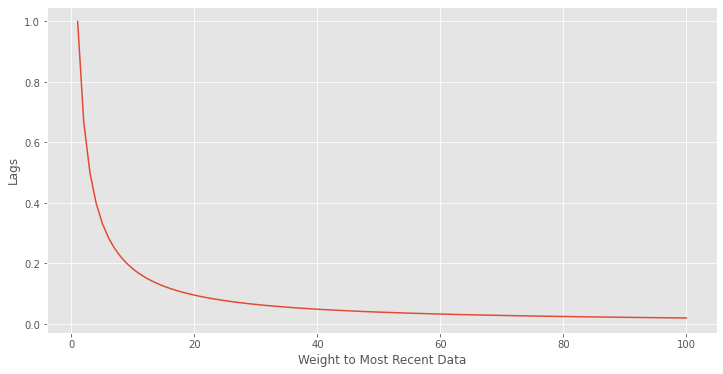

In [6]:
n = np.arange(1, 101)
K = 2/(n+1)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(n, K)
ax.set_ylabel('Lags')
ax.set_xlabel('Weight to Most Recent Data')
plt.show()

In [7]:
usdjpy_ema50 = usdjpy.ewm(span=50, min_periods=50).mean()

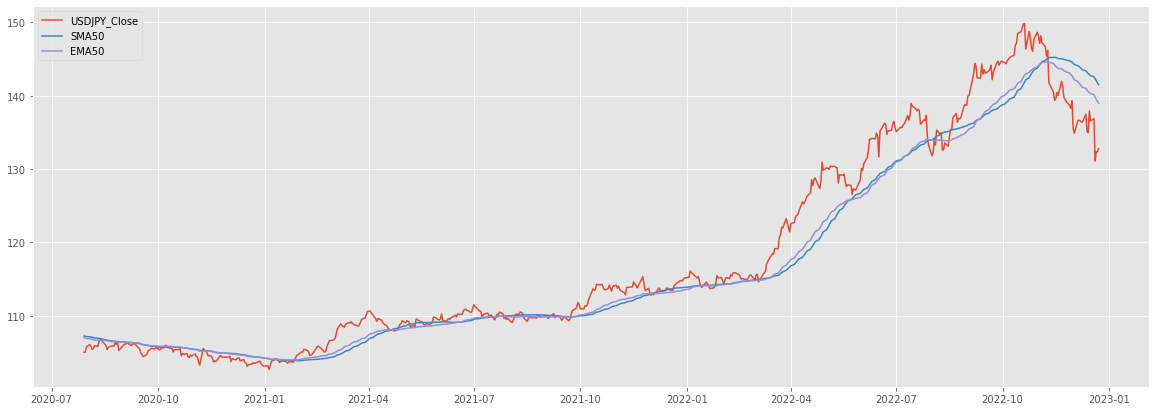

In [8]:
fig, ax = plt.subplots(figsize=(20, 7)) 
ax.plot(usdjpy[-600:], label='USDJPY_Close')
ax.plot(usdjpy_sma50[-600:], label='SMA50')
ax.plot(usdjpy_ema50[-600:], label='EMA50')
ax.legend()
plt.show()

## <font face="gotham" color="purple"> Moving Average Convergence/Divergence (MACD) </font>

Formula of MACD is

$$
\begin{gathered}
M A C D_p=E M A_{12}(p)-E M A_{26}(p) \\
S_{M A C D}=E M A_9(M A C D)
\end{gathered}
$$

In [9]:
def get_macd(price, slow, fast, smooth):
    fast = price.ewm(span = fast, adjust = False).mean()
    slow = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(fast - slow)
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    hist = pd.DataFrame(macd - signal)
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    df.columns = ['macd', 'signal', 'hist']
    return df

In [10]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices, color = 'CornflowerBlue')
    ax2.plot(macd, color = 'tomato', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    # for i in range(len(prices)):
    #     if str(hist[i])[0] == '-':
    #         ax2.bar(prices.index[i], hist[i], color = 'LightCoral')
    #     else:
    #         ax2.bar(prices.index[i], hist[i], color = 'ForestGreen')
    
    for i in range(len(prices)):
        if hist[i] < 0:
            ax2.bar(prices.index[i], hist[i], color = 'LightCoral')
        else:
            ax2.bar(prices.index[i], hist[i], color = 'ForestGreen')

    plt.legend(loc = 'lower right')

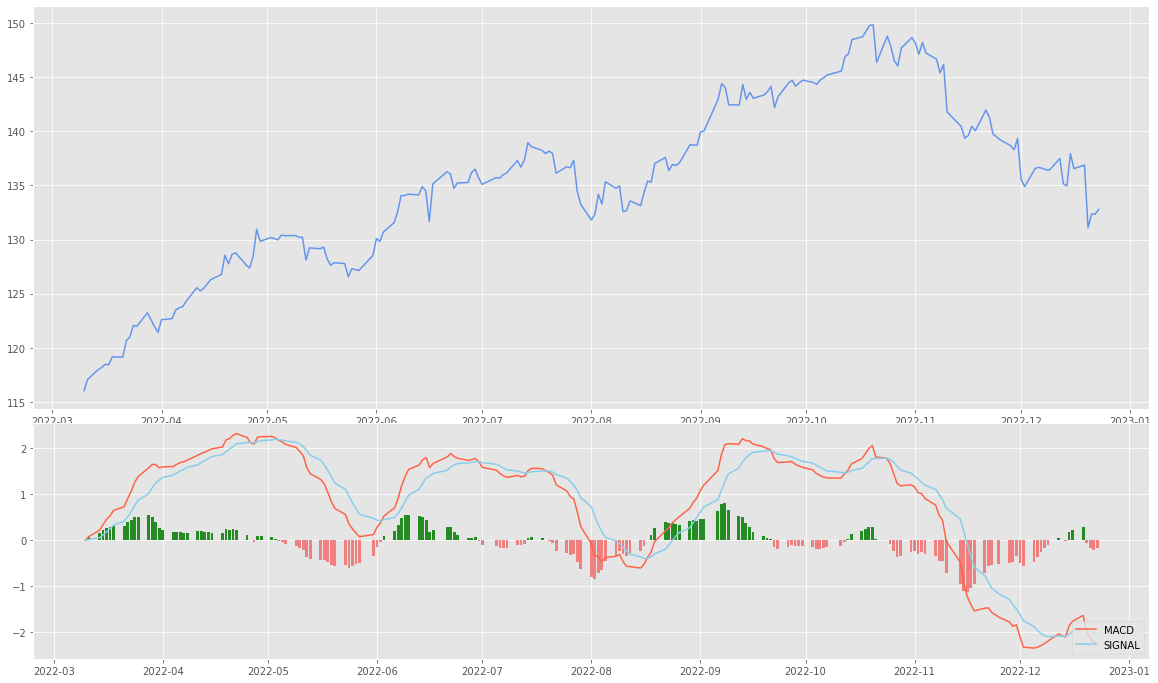

In [11]:
jpy_set = usdjpy[-200:]
usdjpy_macd = get_macd(jpy_set, 26, 12, 9)
plot_macd(jpy_set, usdjpy_macd['macd'], usdjpy_macd['signal'], usdjpy_macd['hist'])

## <font face="gotham" color="purple"> Bollinger Bands </font>

 The upper and lower **Bollinger Bands** are calculated by determining a simple moving average, and then adding/subtracting a specified number of standard deviations from the simple moving average to calculate the upper and lower bands.

$$
BB_{u} = SMA + d \sqrt{\frac{\sum_{i=1}^n(y_i-SMA)^2}{n}}\\
BB_{l} = SMA - d \sqrt{\frac{\sum_{i=1}^n(y_i-SMA)^2}{n}}
$$

In [12]:
def get_bollinger_bands(prices, periods=20):
    sma = get_sma(prices, periods)
    std = prices.rolling(periods).std()
    bollinger_up = sma + std * 2
    bollinger_down = sma - std * 2
    return sma, bollinger_up, bollinger_down

In [13]:
periods = 20
jpy_sma, bollinger_up, bollinger_down = get_bollinger_bands(jpy_set, periods)

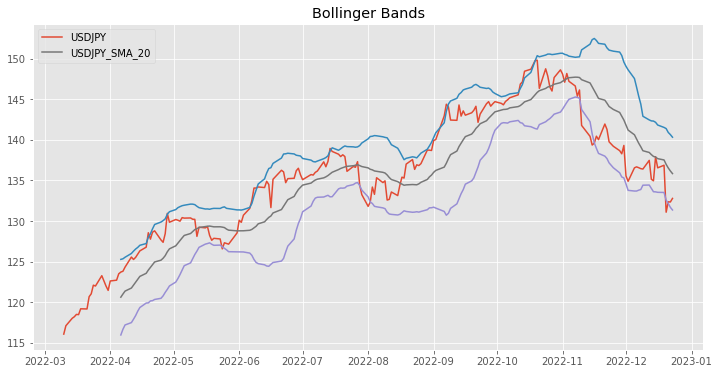

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(jpy_set, label='USDJPY')
ax.plot(bollinger_up)
ax.plot(bollinger_down)
ax.plot(jpy_sma, label='USDJPY_SMA_{}'.format(periods))
ax.legend()
ax.set_title('Bollinger Bands')
plt.show()

# <font face="gotham" color="purple"> Average True Range </font>

Average True Range (ATR) is the average of true ranges over the specified period. ATR measures volatility, taking into account any gaps in the price movement. Typically, the ATR calculation is based on 14 periods, which can be intraday, daily, weekly, or monthly.

Here's the formula

$$
TR=\max{(H-L, |H-C_p|, |L-C_p|)}\\
ATR_t = \frac{ATR_{t-1}(n-1)+TR}{n}
$$

To compute ATR, we need a full set an asset data with OLHC.

In [15]:
eurusd = yf.download(['EURUSD=X'], start = dt.datetime.today()-dt.timedelta(days=1000), \
                 end = dt.datetime.today(), progress = True, \
                 actions= 'inline', interval='1d')
eurusd = eurusd.drop(['Adj Close', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

[*********************100%***********************]  1 of 1 completed


In [16]:
def get_atr(df, periods):
    df['H-L'] = df['High'] - df['Low']
    df['H-Pc'] = abs(df['High'] - df['Close'].shift())
    df['L-Pc'] = abs(df['Low'] - df['Close'].shift())
    df['TR'] = df[['H-L', 'H-Pc', 'L-Pc']].max(axis=1, skipna=False)
    #df['ATR'] = df['TR'].rolling(periods).mean()
    df['ATR'] = df['TR'].ewm(span=periods, adjust=False, min_periods=periods).mean()
    return df['ATR']

In [17]:
atr_periods = 14
eurusd_atr = get_atr(eurusd, atr_periods)
def plot_atr(df):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='EURUSD')
    ax1.legend()
    ax2.plot(df['ATR'], color = 'tomato', linewidth = 1.5, label='ATR {}'.format(atr_periods))
    ax2.legend()

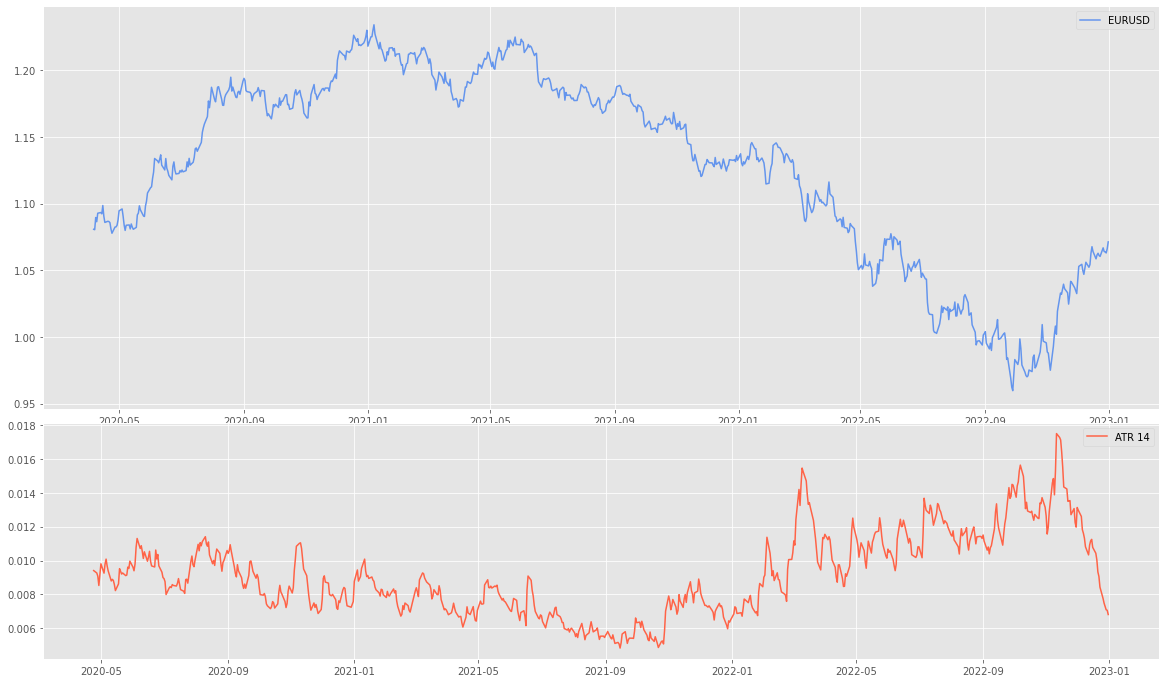

In [18]:
plot_atr(eurusd)

# <font face="gotham" color="purple"> Relative Strength Index </font>

The formula of RSI is

$$
RS = \frac{Avg. Gain}{Avg. Loss}\\
RSI = 100- \frac{100}{1+RS}
$$

In [19]:
def get_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0) # meaning that any value lower than 0, will be set to 0
    down = -1 * close_delta.clip(upper=0) # meaning that any value more than 0, will be set to 0
    
    if ema == True:
        # Use exponential moving average
        avg_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        avg_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        avg_up = up.rolling(window = periods, adjust=False).mean()
        avg_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = avg_up / avg_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [20]:
rsi_periods = 14
eurusd_rsi = get_rsi(eurusd, periods=rsi_periods, ema=True)

In [21]:
def plot_rsi(df, rsi):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='EURUSD')
    ax1.legend()
    ax2.plot(rsi, color = 'tomato', linewidth = 1.5, label='RSI {}'.format(rsi_periods))
    ax2.axhline(70, ls='--', color='grey')
    ax2.axhline(30, ls='--', color='grey')
    ax2.fill_between(eurusd.index, 70, 30, color ='DeepSkyBlue', alpha=.1)
    ax2.legend()

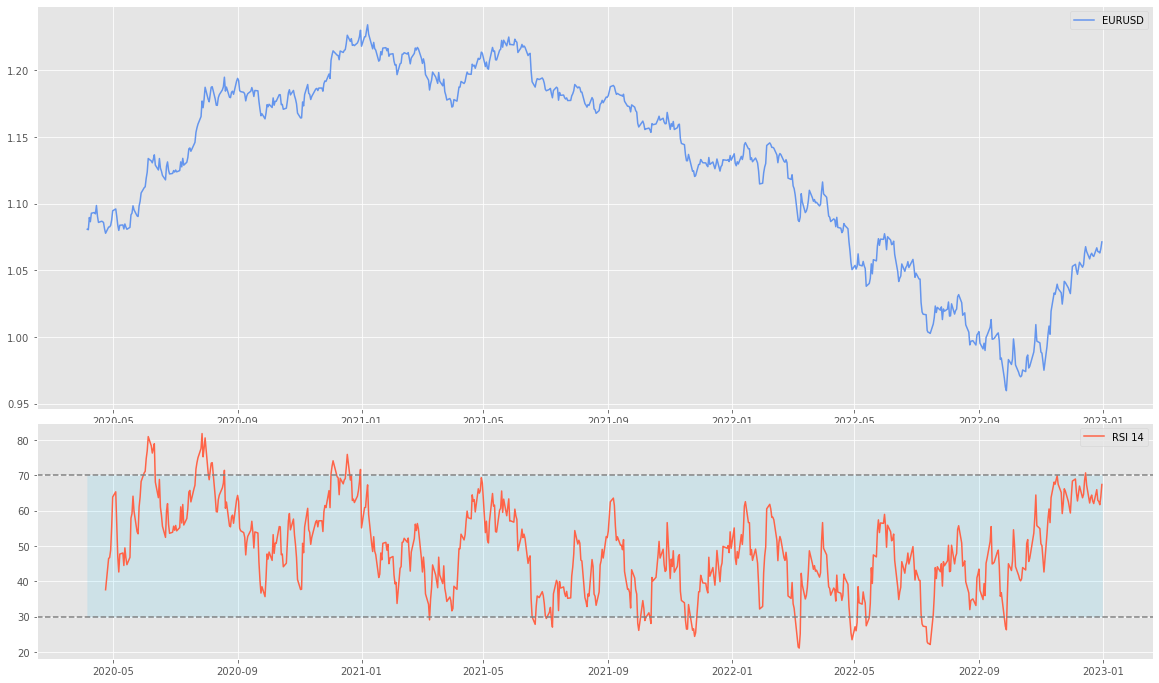

In [22]:
plot_rsi(eurusd, eurusd_rsi)

# <font face="gotham" color="purple"> Average Directional Index </font>

$$
\begin{aligned}
+\mathrm{DI} & =\left(\frac{\text { Smoothed }+\mathrm{DM}}{\mathrm{ATR}}\right) \times 100 \\
-\mathrm{DI} & =\left(\frac{\text { Smoothed }-\mathrm{DM}}{\mathrm{ATR}}\right) \times 100 \\
\mathrm{DX} & =\left(\frac{|+\mathrm{DI}--\mathrm{DI}|}{|+\mathrm{DI}+-\mathrm{DI}|}\right) \times 100 \\
\mathrm{ADX} & =\frac{(\text { Prior ADX } \times 13)+\text { Current ADX }}{14}
\end{aligned}
$$

$\text{DM}$ means directional movement, calculated by current high minus previous high, i.e. $H_t - H_{t-1} = + \text{DM}$ or $L_t - L_{t-1} = - \text{DM}$

In [23]:
lulu = yf.download(['LULU'], start = dt.datetime.today()-dt.timedelta(days=1000), \
                 end = dt.datetime.today(), progress = True, \
                 actions= 'inline', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [24]:
def get_adx(df, periods):
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm = plus_dm.clip(lower=0)
    minus_dm = minus_dm.clip(upper=0)
    df['H-L'] = df['High'] - df['Low']
    df['H-Pc'] = abs(df['High'] - df['Close'].shift())
    df['L-Pc'] = abs(df['Low'] - df['Close'].shift())
    df['TR'] = df[['H-L', 'H-Pc', 'L-Pc']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].ewm(span=periods, adjust=False, min_periods=periods).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/periods).mean() / df['ATR'])
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/periods).mean() / df['ATR']))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (periods - 1)) + dx) / periods
    adx_smooth = adx.ewm(alpha = 1/periods).mean()
    return plus_di, minus_di, adx, adx_smooth

In [25]:
adx_periods = 14
plus_di, minus_di,adx, adx_smooth = get_adx(df=lulu, periods=adx_periods)

In [26]:
def plot_adx(df, adx, adx_smooth,adx_periods):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='LULU')
    ax1.legend()
    ax2.plot(adx, color = 'tomato', linewidth = 1.5, label='ADX unsmoothed {}'.format(adx_periods))
    ax2.plot(adx_smooth, color = 'Brown', linewidth = 1.5, label='ADX smoothed {}'.format(adx_periods))
    ax2.legend()
    plt.show()

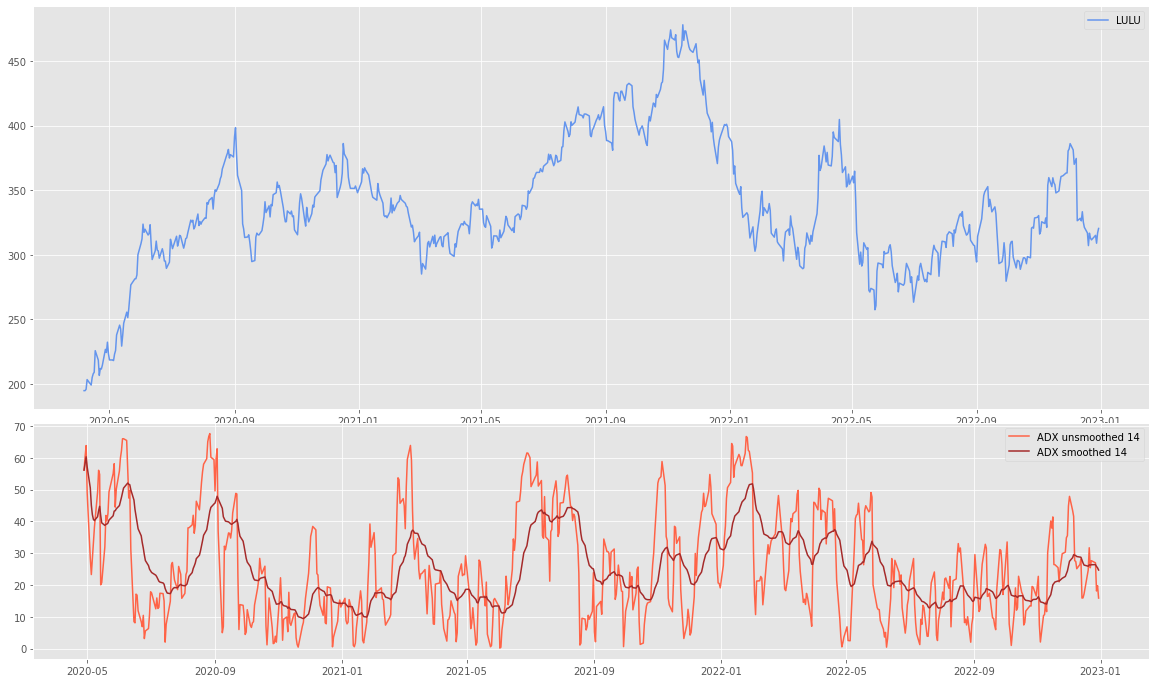

In [27]:
plot_adx(lulu, adx, adx_smooth, adx_periods)

# <font face="gotham" color="purple"> On-Balance Volume </font>

As its name suggests, $\text{OBV}$ is using trading volume to measure the money in-flow or out-flow into a certain asset.

$$
\mathrm{OBV}_t=\mathrm{OBV}_{t-1 }+ \begin{cases}\text { volume, } & \text { if  }C_t>C_{t-1} \\ 0, & \text { if }C_t=C_{t-1} \\ -\text {volume, } & \text { if }C_t<C_{t-1}\end{cases}
$$
where:
$$
C\text{ is close price}\\
\text{volume $=$ Latest trading volume amount}
$$

As a reminder of ```np.where(condition, [x, y])```, this says is that if condition holds ```True``` for some element in our array, the new array will choose elements from $x$, otherwise $y$, which is a convenient way to convert a data into dummy variables. 

In [28]:
obv_periods = 21
def get_obv(df, periods):
    df_temp = df.copy() # if you don't to change the original dataset after running the function, use a copy
    df_temp['Daily_ret'] = df_temp['Adj Close'].pct_change()
    df_temp['Direction'] = np.where(df_temp['Daily_ret']>=0, 1, -1) # meaning that positive return indexed as 1, negative rturn indexed as 0
    df_temp['Direction'][0] = 0 # mannual assign the first value as 0
    df_temp['Volume_adj'] = df_temp['Volume'] * df_temp['Direction']
    df_temp['OBV'] = df_temp['Volume_adj'].cumsum()
    return df_temp['OBV']

In [29]:
obv = get_obv(lulu, obv_periods)

In [30]:
def plot_obv(df, obv):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='LULU')
    ax1.legend()
    ax2.plot(adx, color = 'tomato', linewidth = 1.5, label='OBV {}'.format(obv_periods))
    ax2.legend()
    plt.show()

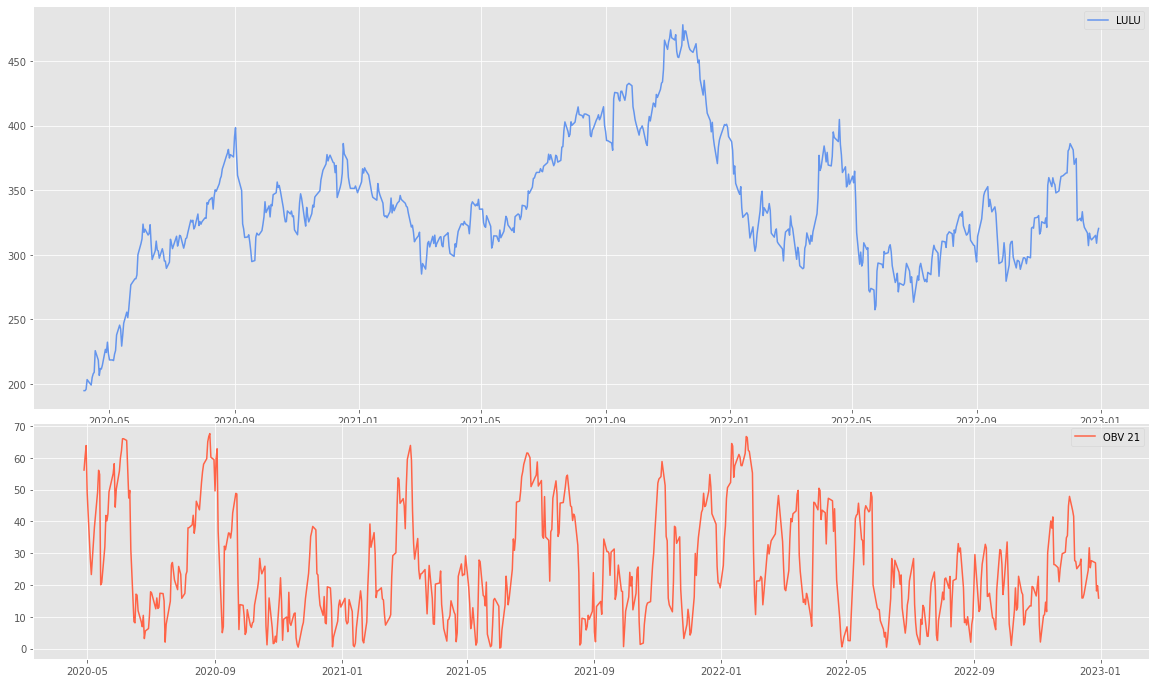

In [31]:
plot_obv(lulu, 21)

# <font face="gotham" color="purple"> Stochastic Oscillators </font>

Similar to RSI, SO also gives indication of overbought and oversold. Formula as below
$$
\% K = \frac{C-L_n}{H_n - L_n}\times 100
$$
where $C$ is the current closing price, $L_n$ is the lowest price in recent $n$ period, the default setting $n=15$. And $\%D$ is just the mean value of $\%K$.
$$
\% D = \frac{1}{d}\sum_{i=i}^d \%K_i
$$
where by default $d=3$.

Common ways of using Stochastic Oscillator:
1. Overbought/Oversold indicates potential reversal
2. Crossover of $\%K$ and $\%D$
3. Divergence between price and oscillator indicates potential reversal

In [32]:
k_periods=14
d_periods=3
def get_stoc_oslr(df, k_periods, d_periods):
    df_temp = df.copy()
    df_temp['n-high'] = df_temp['High'].rolling(k_periods).max()
    df_temp['n-low'] = df_temp['Low'].rolling(k_periods).min()
    df_temp['%K'] = (df_temp['Close'] - df_temp['n-low'])*100/(df_temp['n-high'] - df_temp['n-low'])
    df_temp['%D'] = df_temp['%K'].rolling(d_periods).mean()
    return df_temp['%K'], df_temp['%D']

In [33]:
def plot_stoc_oslr(df, K_perc, D_perc, k_periods, d_periods):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='LULU')
    ax1.legend()
    ax2.plot(K_perc, color = 'tomato', linewidth = 1.5, label=r'$\%K$ {}'.format(k_periods))
    ax2.plot(D_perc, color = 'Navy', linewidth = 1.5, label=r'$\%D$ {}'.format(d_periods))
    ax2.legend()
    plt.show()

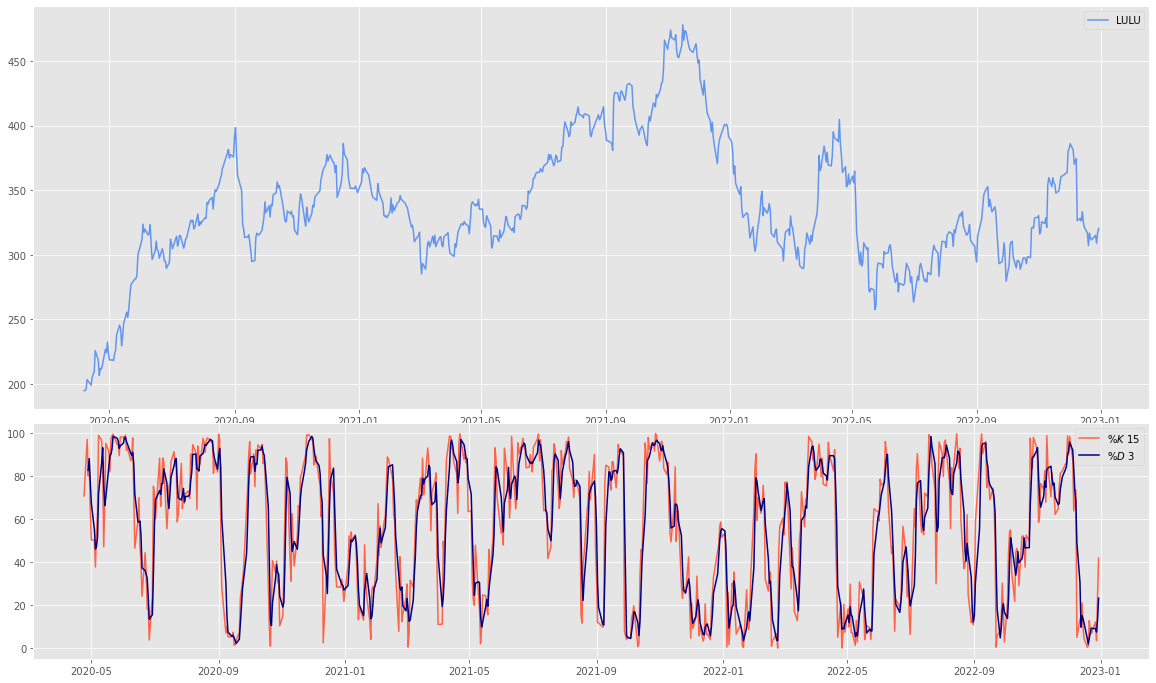

In [34]:
K_perc, D_perc = get_stoc_oslr(lulu, k_periods, d_periods)
plot_stoc_oslr(lulu,K_perc,D_perc, 15, 3)

# <font face="gotham" color="purple"> Libraries for Technical Analysis </font>

The most famous Python environment library is <a href='https://ta-lib.org/'>TA-lib</a>, which was initially an open source library run in C language in 1990s, but has been unofficially adapted to Python by volunteers, however lots of bugs present in Windows environment.

Another choice would be <a href=https://twopirllc.github.io/pandas-ta/>pandas-ta</a>, which is complete written in Python and easy access to data frame, it needs TA-lib to run candle pattern functions.

Here's an example of pandas-ta. 

In [37]:
citi = yf.download(['C'], start = dt.datetime.today()-dt.timedelta(days=1000), \
                 end = dt.datetime.today(), progress = True, \
                 actions= 'inline', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [44]:
rsi_period, sma_period = 14, 60
citi['RSI'] = ta.rsi(close=citi['Adj Close'], length=rsi_period)
citi['SMA60'] = ta.sma(close=citi['Adj Close'], length=sma_period)
def plot_indicators(df):
    plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(df['Close'], color = 'CornflowerBlue', label='Citi')
    ax1.plot(df['SMA60'], color = 'tomato', linewidth = 1.5, label=r'SMA {}'.format(sma_period))
    ax1.legend()
    
    ax2.plot(citi['RSI'], color = 'Navy', linewidth = 1.5, label=r'RSI {}'.format(rsi_period))
    ax2.legend()
    plt.show()

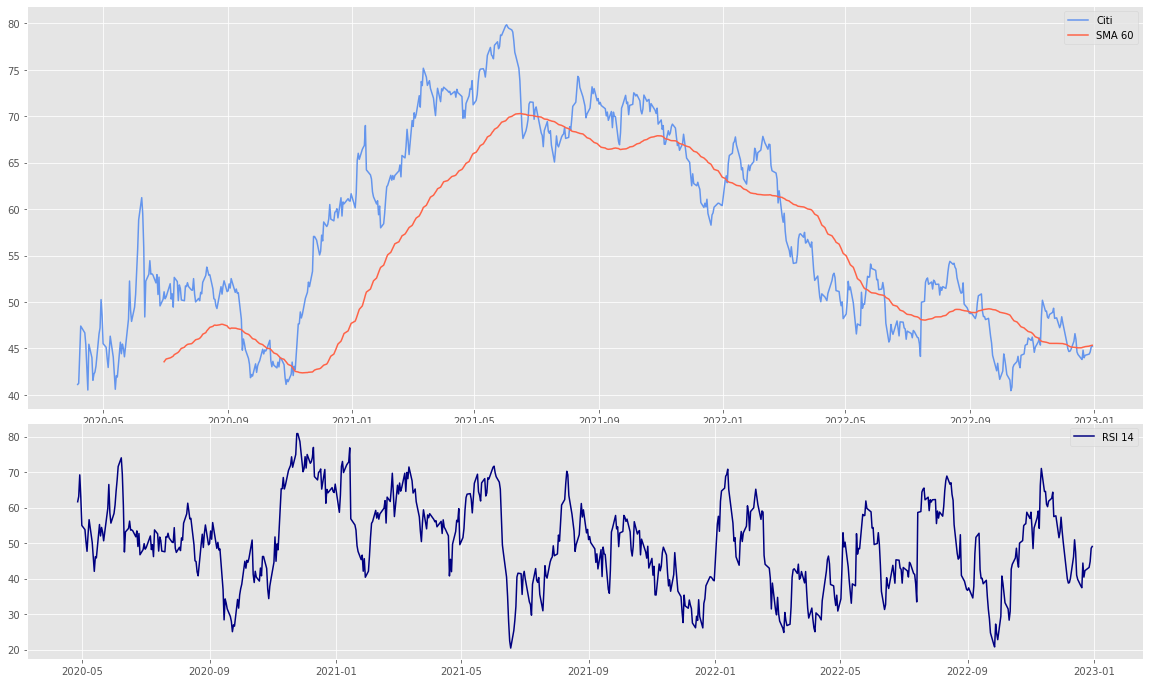

In [45]:
plot_indicators(citi)